STREAMING REC PROJECT

In [1]:
#set Up / Imports
!pip install pandas numpy matplotlib scikit-learn

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import random
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.metrics import mean_squared_error

os.chdir(r"C:\Users\Emmet\PycharmProjects\streaming-recs-project")



In [2]:
#Data Loading and Sparsity Check

#load ratings and movies. combine into df
ratings = pd.read_csv('data/ml32/ratings.csv')
movies = pd.read_csv('data/ml32/movies.csv')
df = ratings.merge(movies, on='movieId', how='left')

# sparsity (how much of the df is empty)
n_users = df['userId'].nunique()
n_items = df['movieId'].nunique()
sparsity = 1 - (len(df)/ (n_users*n_items))


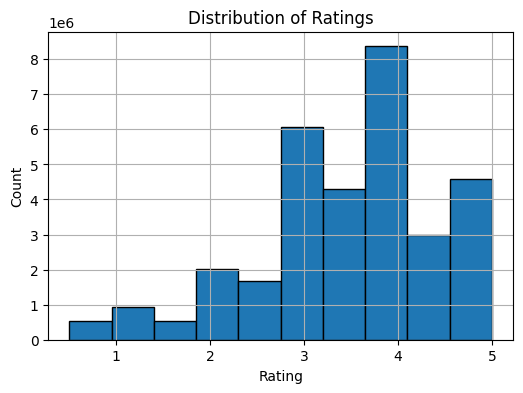

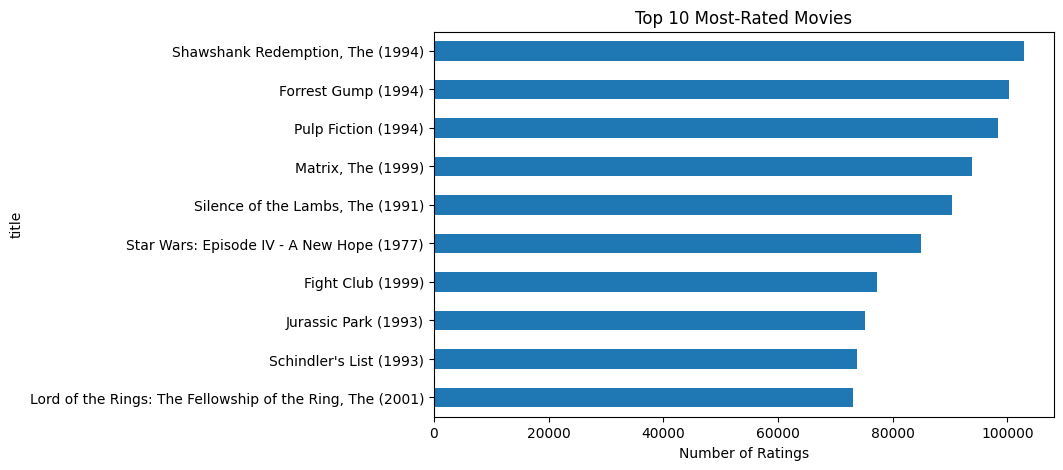

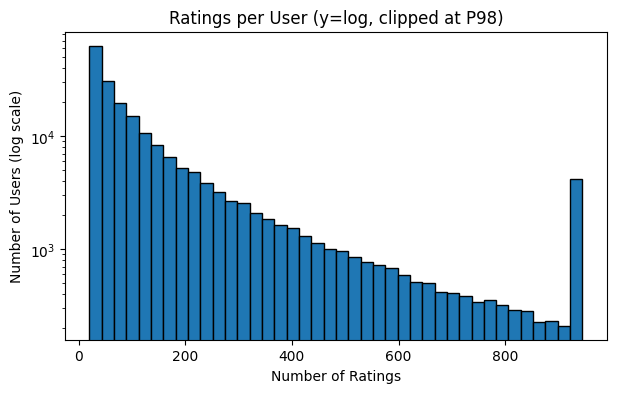

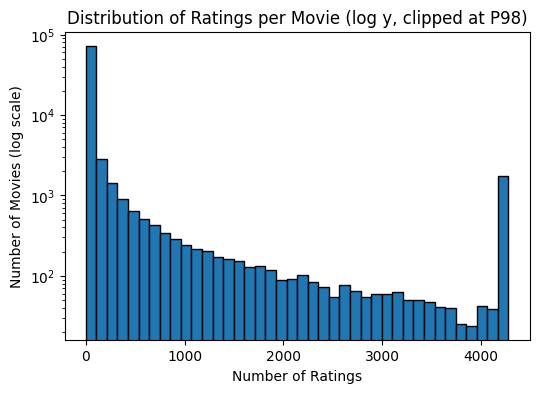

Number of users: 200948
Number of movies: 84432
Number of ratings: 32000204
Sparsity: 0.9981


In [3]:
#Explore / Check Data
# checks to see if data is present, and eyeball if ratings and distrobutions are making sense across the data.

# Histogram of rating values
plt.figure(figsize=(6,4))
df['rating'].hist(bins=10, edgecolor='black')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# Top 10 most-rated movies -- plot for visual
top_movies = (
    df.groupby('title')['rating']
      .count()
      .sort_values(ascending=False)
      .head(10)
)

plt.figure(figsize=(8,5))
top_movies.plot(kind='barh')
plt.title("Top 10 Most-Rated Movies")
plt.xlabel("Number of Ratings")
plt.gca().invert_yaxis()  # so the top movie is at the top
plt.show()


# Ratings per user -- plot for visual
ratings_per_user = df.groupby('userId')['rating'].count()
fig, ax = plt.subplots(figsize=(7,4))
ax.hist(ratings_per_user.clip(upper=ratings_per_user.quantile(0.98)),
        bins=40, edgecolor='black')
ax.set_yscale('log')
ax.set_title("Ratings per User (y=log, clipped at P98)")
ax.set_xlabel("Number of Ratings")
ax.set_ylabel("Number of Users (log scale)")
plt.show()


# Ratings per movie -- plot for visual
ratings_per_movie = df.groupby('movieId')['rating'].count()
cap_value = ratings_per_movie.quantile(0.98)
plt.figure(figsize=(6,4))
plt.hist(ratings_per_movie.clip(upper=cap_value),
         bins=40, edgecolor='black')
plt.yscale('log')  # log-based y-axis
plt.title("Distribution of Ratings per Movie (log y, clipped at P98)")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies (log scale)")
plt.show()


#summary Table
print(f"Number of users: {n_users}")
print(f"Number of movies: {n_items}")
print(f"Number of ratings: {len(df)}")
print(f"Sparsity: {sparsity:.4f}")

In [4]:
#Most Watched recommender
# shows top 10 most watched (IE most rated) movies.

#count how many ratings each movie got and sort.
movie_count = (df.groupby('movieId')['rating']
               .count()
               .sort_values(ascending=False)
               )

#join with the movies DataFrame to get titles
movie_count = movie_count.reset_index(name='number of ratings') # resets to dataframe and renames values column
popular = movie_count.merge(
    movies[['movieId', 'title']], #adds titles back onto movieId counts
    on='movieId',
    how='left'
)

# Get the top 10 most-rated movies
most_watched = popular.head(10)
most_watched.index = range(1, len(most_watched) + 1) #reindexes from 1 for cleaner printing

# show em!
print("Top 10 Most Watched Movies:")
print(most_watched[['title', 'number of ratings']])



Top 10 Most Watched Movies:
                                                title  number of ratings
1                    Shawshank Redemption, The (1994)             102929
2                                 Forrest Gump (1994)             100296
3                                 Pulp Fiction (1994)              98409
4                                  Matrix, The (1999)              93808
5                    Silence of the Lambs, The (1991)              90330
6           Star Wars: Episode IV - A New Hope (1977)              85010
7                                   Fight Club (1999)              77332
8                                Jurassic Park (1993)              75233
9                             Schindler's List (1993)              73849
10  Lord of the Rings: The Fellowship of the Ring,...              73122


In [5]:
#Average Rating Recommender


#per movie mean rating and number of ratings
movie_stats = df.groupby('movieId')['rating'].agg(['mean','count']).reset_index()
movie_stats.columns = ['movieId','avg rating','number of ratings']

#sets minimum number of ratings to be considered and ranks the average of the remaining
min_rating = 2000
filtered_movies = (movie_stats[movie_stats['number of ratings'] >= min_rating]
    .sort_values(by='avg rating', ascending=False)
)

#adds back titles
avg_rating_df = filtered_movies.merge(
    movies[['movieId', 'title']],
    on='movieId',
    how='left'
)

#print results!
top_rated = avg_rating_df.head(10)
top_rated.index = range(1, len(top_rated) + 1)
print(top_rated[['title', 'avg rating', 'number of ratings']])


                                          title  avg rating  number of ratings
1                           Planet Earth (2006)    4.444369               2948
2                       Band of Brothers (2001)    4.426539               2811
3              Shawshank Redemption, The (1994)    4.404614             102929
4                         Godfather, The (1972)    4.317030              66440
5                               Parasite (2019)    4.312254              11670
6                           12 Angry Men (1957)    4.265311              21863
7                    Usual Suspects, The (1995)    4.265070              67750
8                Godfather: Part II, The (1974)    4.264468              43111
9   Seven Samurai (Shichinin no samurai) (1954)    4.249622              16531
10                              Whiplash (2013)    4.240097               3080


In [6]:
#BUILD RECOMMENDER
#will recommend a movie to a user based on other movies they've rated. Starting with users in the data already.
#create user-item rating matrix
#To make sure the df isn't too big we're filtering down to the 500 most active users and most popular movies.

busy_users = df['userId'].value_counts().head(1000).index
most_watched_movies = df['movieId'].value_counts().head(1000).index
df_filtered = df[df['userId'].isin(busy_users) & df['movieId'].isin(most_watched_movies)]

#create user / rating matrix. users as rows, movies as columns
user_movie_matrix = df_filtered.pivot_table(
    index='userId',
    columns='movieId',
    values = 'rating',
)

#print user_movie_matrix to make sure it makes sense.
print(user_movie_matrix.shape) #number of users and movies
print(user_movie_matrix.head(3)) # preview first 3 users




(1000, 1000)
movieId  1       2       3       5       6       7       10      11      \
userId                                                                    
28          4.0     3.0     4.0     2.0     3.0     3.0     3.0     5.0   
188         4.0     4.0     NaN     3.5     5.0     5.0     NaN     3.0   
265         5.0     4.0     NaN     NaN     NaN     NaN     4.0     NaN   

movieId  16      17      ...  168252  171763  174055  176371  177765  187593  \
userId                   ...                                                   
28          3.0     4.0  ...     4.0     5.0     5.0     5.0     4.5     3.5   
188         5.0     2.5  ...     NaN     NaN     NaN     NaN     NaN     NaN   
265         4.0     NaN  ...     4.5     5.0     NaN     NaN     3.0     4.0   

movieId  195159  202439  204698  207313  
userId                                   
28          5.0     5.0     NaN     4.5  
188         NaN     NaN     NaN     NaN  
265         4.0     5.0     2.0     4.5  


In [7]:
#compute user to user rating similarity

#using cosine similarity to measure how similar two vectors are based on angle between them.
#(dot product / product of their magnitude) ie and Inner Product space (Linear Algebra)
#all users’ contributions are summed, then normalized, so every user’s rating pattern influences the similarity, 0s have no effect

#fill the user/movie matrix with 0s for missing values
filled_um_matrix = user_movie_matrix.fillna(0)

#use cosine similarity function found
#why transpose? sklearn.metrics.pairwise.cosine_similarity is between rows.
movie_similarity = cosine_similarity(filled_um_matrix.T) #make movies as the rows - run similarity. returns array

#create dataframe for looking up and labeling
movie_similarity_df = pd.DataFrame(
    movie_similarity,
    index=filled_um_matrix.columns,   # confirm as movieIds
    columns=filled_um_matrix.columns  # confirm as movieIds
)

#print to make sure things are going mostly right
print(user_movie_matrix.shape) #number of users and movies
print(movie_similarity_df.head(3))



(1000, 1000)
movieId    1         2         3         5         6         7         10      \
movieId                                                                         
1        1.000000  0.842467  0.605342  0.603769  0.831402  0.592356  0.806595   
2        0.842467  1.000000  0.568206  0.597316  0.724433  0.565365  0.760221   
3        0.605342  0.568206  1.000000  0.626928  0.547720  0.532654  0.601089   

movieId    11        16        17      ...    168252    171763    174055  \
movieId                                ...                                 
1        0.688695  0.800666  0.643537  ...  0.679624  0.633739  0.634720   
2        0.606423  0.692751  0.532427  ...  0.632415  0.590987  0.540222   
3        0.584318  0.545070  0.470070  ...  0.373186  0.347259  0.352094   

movieId    176371    177765    187593    195159    202439    204698    207313  
movieId                                                                        
1        0.655036  0.622675  0.617141  0

In [8]:
#Similarity Checking Function (Optional to run/intialize)
#You can skip this cell if you want. the function and variable don't get called anywhere.
#this is mostly here to make sure the similarity dataframe is behaving as expected

def get_similar_movies(movie_id, item_similarity_df, movies, top_n=10):
    similar_scores = item_similarity_df[movie_id].drop(movie_id)
    similar_ids = similar_scores.sort_values(ascending=False).head(top_n).index

    return movies[movies['movieId'].isin(similar_ids)][['title']]

movie_marker = movies.loc[movies['title'] == 'Toy Story (1995)', 'movieId'].values[0]
print(get_similar_movies(movie_marker, movie_similarity_df, movies, top_n=5))

                                                  title
257           Star Wars: Episode IV - A New Hope (1977)
475                                Jurassic Park (1993)
1168  Raiders of the Lost Ark (Indiana Jones and the...
1237                          Back to the Future (1985)
3021                                 Toy Story 2 (1999)


In [9]:
#recommend movies to a random user in the dataframe

def recommend_for_user(user_id, user_movie_matrix, movie_similarity_df, top_n=10):
    #get ratings for the user entered
    user_ratings = user_movie_matrix.loc[user_id].dropna()

    # Make sure we're using movie titles, not IDs
    if not set(user_ratings.index).issubset(movie_similarity_df.columns):
        raise ValueError("Mismatch between user/movie matrix columns and similarity matrix.")

    #stores recommendation scores for movies the user hasn't seen yet
    scores = {}

    #looks at each movie the user rated
    for movie, rating in user_ratings.items():
        similar_movie = movie_similarity_df[movie].drop(movie)

        #looks for movies with similar affiliation
        for similar_movie, similarity in similar_movie.items():
            #only consider if user hasnt seen movie
            if pd.isna(user_movie_matrix.loc[user_id, similar_movie]):
                #weights a score based on how similar the movie is * how highly that movie is rated.
                #that is accumulated across multiple movies compared. A movie's recommendation score can thus get multiple relative bumps.
                scores[similar_movie] = scores.get(similar_movie, 0) + similarity*rating

    #sort the movies by the cumulative recommendation scores
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]

    #creates a list of titles (not just movieId).
    ranked_with_titles = [(movies.loc[movies['movieId'] == mid, 'title'].values[0], score) for mid, score in ranked]

    return ranked_with_titles



#example use:

user_id = random.choice(user_movie_matrix.index.tolist()) # pick a user from your filtered dataset
recommendations = recommend_for_user(user_id, user_movie_matrix, movie_similarity_df, top_n=5)

print(f"Top recommendations for user {user_id}:")
for title, score in recommendations:
    print(f"{title} (score: {score:.3f})")



Top recommendations for user 51289:
High Fidelity (2000) (score: 1953.214)
Raising Arizona (1987) (score: 1904.904)
Dark City (1998) (score: 1886.558)
Matrix Revolutions, The (2003) (score: 1885.162)
Chasing Amy (1997) (score: 1844.745)


In [ ]:
# double checking data one more time!
# it would probably be good to try to validate the work again quick before moving on.

def check_shapes_and_sparsity(ratings_df, user_movie_matrix):

    # check and return shapes and sparcity checks
    sparsity = 1 - (user_movie_matrix.notna().sum().sum() / user_movie_matrix.size)
    print(f"Ratings dataframe shape: {ratings_df.shape}")
    print(f"User–Movie matrix shape: {user_movie_matrix.shape}")
    print(f"Sparsity (empty cells %): {sparsity:.2%}")
    return {"sparsity": sparsity, "users": user_movie_matrix.shape[0], "movies": user_movie_matrix.shape[1]}

def check_popular_movies(ratings_df, movies, n=10):

    # return top rated movies and their counts
    popular = (ratings_df.groupby('movieId')['rating']
                 .count()
                 .sort_values(ascending=False)
                 .head(n)
                 .rename('num_ratings')
                 .reset_index()
                 .merge(movies[['movieId','title']], on='movieId', how='left'))
    print(f"Top {n} most rated movies:")
    return popular[['title','num_ratings']]


def check_movie_neighbors(title, movies, user_movie_matrix, top_n=10):
    # top n most similar movies to a given title using cosine similarity.

    # build similarity matrix (fill NaN with 0 just for similarity math)
    item_sims = cosine_similarity(user_movie_matrix.fillna(0).T)
    item_similarity_df = pd.DataFrame(
        item_sims,
        index=user_movie_matrix.columns,
        columns=user_movie_matrix.columns
    )

    # look up movieId
    ids = movies.loc[movies['title'] == title, 'movieId']
    if ids.empty:
        raise ValueError(f"Movie title '{title}' not found.")
    movie_id = ids.iloc[0]

    # find neighbors
    neighbors = (item_similarity_df[movie_id]
                   .drop(movie_id)
                   .sort_values(ascending=False)
                   .head(top_n)
                   .rename('similarity')
                   .reset_index()
                   .merge(movies[['movieId','title']], on='movieId', how='left'))
    print(f"Top {top_n} neighbors for: {title}")
    return neighbors[['title','similarity']]


check_shapes_and_sparsity(movie_similarity_df, user_movie_matrix)
check_popular_movies(movie_similarity_df, movies)


In [13]:
#Build interactive recommender
#this is the big thing here - lets take the similarity dataframe I've been working with an give myself (or another user) recommendations.



popularity = df['movieId'].value_counts()

def pick_next_movie(user_ratings, movies, item_similarity_df, popularity, min_ratings=300):
    #picks movies to ask about based on previous user ratings.
    # Heuristic - chooses a movie most similar to the highest rated movie so far.
    # Asks about random movie every few steps
    # skips multiple installments of same franchise

    if not user_ratings:
    #start with popular movie
        popular_choice = popularity[popularity>min_ratings].index
        start_movie = random.choice(popular_choice)
        return movies.loc[movies['movieId'] == start_movie].iloc[0]

    #find users current favorite
    fav_movie = max(user_ratings, key=user_ratings.get)

    # If the favorite movie isn't in the similarity matrix, fall back to popular
    if fav_movie not in item_similarity_df.columns:
        popular_choice = popularity[popularity > min_ratings].index
        start_movie = random.choice(popular_choice)
        return movies.loc[movies['movieId'] == start_movie].iloc[0]

    # every 3rd pick try a random movie
    if len(user_ratings) % 3 == 0:
        popular_choice = popularity[popularity > min_ratings].sample(1).index[0]
        return movies.loc[movies['movieId'] == popular_choice].iloc[0]

    #find a similar unseen movie
    sims = item_similarity_df[fav_movie].drop(fav_movie).sort_values(ascending=False)
    for candidate in sims.index:
        if candidate not in user_ratings and popularity.get(candidate, 0) > min_ratings:
            return movies.loc[movies['movieId'] == candidate].iloc[0]


def too_similar(title, asked_titles):
    for t in asked_titles:
        if title.split()[0] in t or t.split()[0] in title:
            return True
    return False


def interactive_recommender(movies, item_similarity_df, top_n=5):
    #asks user to rate 10 random movies, then recommends movies based on ratings.

    print("Please rate these movies from 1-5, or 0 if you haven't seen it.\n")

    # get 10 ratings of films the user has seen. Don't stop until 10 films are rated.
    user_ratings = {}
    asked_movies = set() #movieId
    asked_titles = set() #str title
    rated = 0 #number of films seen

    while rated < 10:
        movie = pick_next_movie(user_ratings, movies, item_similarity_df, popularity)
        if movie['movieId'] in asked_movies:
            continue
        if too_similar(movie['title'], asked_titles):
            continue
        asked_movies.add(movie['movieId'])
        asked_titles.add(movie['title'])

        while True:
            try:
                rating = float(input(f"Rate this movie 1-5 (or 0 if you havent seen it): {movie['title']}: "))
                if 0 <= rating <= 5:
                    break
                else:
                    print("Please enter a rating from 0 and 5")
            except ValueError:
                print("invalid input - enter a number between 0 and 5")
        if rating > 0:
            user_ratings[movie['movieId']] = rating
            rated += 1

    # score other movies based on similarity
    scores = {}


    for movie_id, rating in user_ratings.items():
        if movie_id not in item_similarity_df.columns:
            continue
        similar_movies = item_similarity_df[movie_id].drop(movie_id)
        for sim_movie, similarity in similar_movies.items():
            if sim_movie not in user_ratings:
                scores[sim_movie] = scores.get(sim_movie, 0) + (similarity * rating) / np.log1p(popularity[sim_movie])

    # rank top recommendations
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]

    print(f"Top recommendations for you:")
    for i, (mid, score) in enumerate(ranked, 1):
        title = movies.loc[movies['movieId'] == mid, 'title'].values[0]
        print(f"{i}. {title} (score: {score:.3f})")


interactive_recommender(movies, movie_similarity_df, top_n=5)

Please rate these movies from 1-5, or 0 if you haven't seen it.

Top recommendations for you:
1. Thor: The Dark World (2013) (score: 2.860)
2. Captain America: The Winter Soldier (2014) (score: 2.794)
3. X-Men: Days of Future Past (2014) (score: 2.784)
4. Iron Man 3 (2013) (score: 2.775)
5. Captain America: The First Avenger (2011) (score: 2.775)
